In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import argparse
import os
import torch
from torch.autograd import Variable
from tqdm import tqdm
import time
from models.deep_isp_model import DenoisingNet
from msr_demosaic import MSRDemosaic
from audio_dataset import AudioDataset, AudioGenDataset
import deep_isp_utils as utils
from collections import OrderedDict
import shutil
import matplotlib.pyplot as plt
from loss import *
from datetime import datetime

import numpy as np
from torch import nn
import quantize
import actquant
import IPython.display as ipd


transformation = utils.JointCompose([
    utils.JointHorizontalFlip(),
    utils.JointVerticalFlip(),
    #utils.JointNormailze(means = [0.485,0.456,0.406],stds = [1,1,1]), #TODO consider use
    utils.JointToTensor(),
])
val_transformation = utils.JointCompose([
    #utils.JointNormailze(means = [0.485,0.456,0.406],stds = [1,1,1]),
    utils.JointToTensor(),
])

Here we put the parameters of the model

In [2]:
num_denoise_layers = 20
quant = False
inject_noise = False
quant_bitwidth = 32
quant_epoch_step = 50
inject_act_noise = False
act_bitwidth = 32
act_quant = False
quant_start_stage = 0
weight_relu = False
weight_grad_after_quant = False
random_inject_noise = False
step = 19
num_workers = 1
wrpn = False

gpus = [0]

The function ```load model``` loads a .tar file from a pretrained model

In [3]:
def load_model(model,checkpoint):

    new_state_dict = OrderedDict()
    for k, v in checkpoint['state_dict'].items():
        name = k[7:] if k[0:6] == 'module.' else k # remove `module. if needed (happen when the model created with DataParallel
        #new_state_dict[name] = v
        new_state_dict[name] = v if v.dim() > 1 or 'num_batches_tracked' in name else v*v.new_ones(1)

    # load params
    model.load_state_dict(new_state_dict, strict=False) #strict false in case the loaded doesn't have alll variables like running mean


In [4]:
model = DenoisingNet(in_channels=2, num_denoise_layers=num_denoise_layers, quant=quant , noise=inject_noise, bitwidth=quant_bitwidth, quant_epoch_step=quant_epoch_step,
                         act_noise=inject_act_noise , act_bitwidth= act_bitwidth , act_quant=act_quant, use_cuda=(gpus is not None), quant_start_stage=quant_start_stage,
                         weight_relu=weight_relu, weight_grad_after_quant=weight_grad_after_quant, random_inject_noise = random_inject_noise
                         , step=step, wrpn=wrpn)
model.cuda()
device = 'cuda:' + str(0)
torch.cuda.set_device(0)

checkpoint_file = "/home/simon/denoise/Denoising-drone-rotors/output/2019-05-22_12-22-02/checkpoint.pth.tar" # checkpoint location
if os.path.isfile(checkpoint_file):
    print("loading checkpoint {}".format(checkpoint_file))
    checkpoint = torch.load(checkpoint_file, map_location=device)
    load_model(model, checkpoint)
    

/home/simon/denoise/Denoising-drone-rotors/models/deep_isp_model.py:53: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight, mode='fan_out')
/home/simon/denoise/Denoising-drone-rotors/models/deep_isp_model.py:55: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)


loading checkpoint /home/simon/denoise/Denoising-drone-rotors/output/2019-05-22_12-22-02/checkpoint.pth.tar


In [5]:
# Load dataset

# datapath = '/home/simon/denoise/dataset/data/data.h5'
# testset = MSRDemosaic(root=datapath, train=False, transform=val_transformation)
# test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=num_workers)

# use train set to check overfitting
# testset = AudioDataset(data_h5_path=datapath, train=True)
# test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=num_workers)

# trainset = AudioGenDataset("/home/simon/denoise/dataset/generator/")
# train_loader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=num_workers)
# testset = AudioGenDataset("/home/simon/denoise/dataset/generator/", train=False)
# test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=num_workers)

# with RPM ##########################

trainset = AudioGenDataset("/home/simon/denoise/dataset/generator/", train=True, dataset_size=100, add_rpm=True)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=num_workers)

# testset = AudioGenDataset("/home/simon/denoise/dataset/generator/", train=False, dataset_size=100, add_rpm=True)
# test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=num_workers)

test_loader = train_loader

# testset = AudioDataset(data_h5_path=datapath, train=False)
# test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=num_workers)


  0%|          | 0/100 [00:00<?, ?it/s]

Building dataset


 13%|█▎        | 13/100 [00:00<00:07, 11.83it/s]

Exception: sample too silent


 19%|█▉        | 19/100 [00:00<00:04, 16.23it/s]

Exception: sample too silent
Exception: sample too silent
Exception: sample too silent


 25%|██▌       | 25/100 [00:01<00:03, 20.00it/s]

Exception: sample too silent
Exception: sample too silent
Exception: sample too silent
Exception: sample too silent


 37%|███▋      | 37/100 [00:01<00:02, 24.19it/s]

Exception: sample too silent
Exception: sample too silent
Exception: sample too silent
Exception: sample too silent
Exception: sample too silent


 43%|████▎     | 43/100 [00:01<00:02, 24.98it/s]

Exception: sample too silent
Exception: sample too silent
Exception: sample too silent
Exception: sample too silent


 49%|████▉     | 49/100 [00:02<00:02, 24.99it/s]

Exception: sample too silent
Exception: sample too silent


 58%|█████▊    | 58/100 [00:02<00:01, 25.70it/s]

Exception: sample too silent


 67%|██████▋   | 67/100 [00:02<00:01, 26.45it/s]

Exception: sample too silent
Exception: sample too silent
Exception: sample too silent


 76%|███████▌  | 76/100 [00:03<00:00, 26.03it/s]

Exception: sample too silent
Exception: sample too silent


 82%|████████▏ | 82/100 [00:03<00:00, 25.90it/s]

Exception: sample too silent
Exception: sample too silent
Exception: sample too silent
Exception: sample too silent
Exception: sample too silent


 94%|█████████▍| 94/100 [00:03<00:00, 27.04it/s]

Exception: sample too silent


 97%|█████████▋| 97/100 [00:03<00:00, 26.22it/s]

Exception: sample too silent
Exception: sample too silent
Exception: sample too silent
Exception: sample too silent
Exception: sample too silent


100%|██████████| 100/100 [00:04<00:00, 25.29it/s]


  0%|          | 0/90 [00:00<?, ?it/s]

data source
data shape: (1025, 94)
5.427084


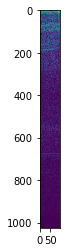

In [ ]:
import IPython.display as ipd
from preprocess_audio.preprocess_audio import *
# convert back to audio
from preprocess_audio.postprocess_audio import *


# ipd.Audio('/home/simon/denoise/dataset/audio/file_example_WAV_1MG.wav')
# ipd.Audio(x, rate=sr) # load a NumPy array

def unbias_image(img):
    return  torch.clamp(img, 0 , 1.).data.squeeze(0).cpu().numpy()#.transpose(1, 2, 0) + 0.5  #the clamp is becuase the value should be between 0-1


# Run inference
loader = test_loader
N_CHANNELS = 1025
N_FFT = 2048
fs = 48000
n = 5

# create_spectogram
# def read_audio_spectum(filename):
#     x, fs = librosa.load(filename)
#     S = librosa.stft(x, N_FFT)
#     p = np.angle(S)
#     return np.log1p(np.abs(S[np.newaxis,:,:1000])), fs

# a_content, fs = read_audio_spectum("/home/simon/denoise/dataset/audio/file_example_WAV_1MG.wav")
# N_SAMPLES = a_content.shape[2]
# N_CHANNELS = a_content.shape[1]
# # a_style = a_style[:, :N_CHANNELS, :N_SAMPLES]

# t = np.zeros_like(a_content)
# a = np.zeros_like(a_content[0])
# a[:N_CHANNELS,:] = np.exp(t[0]) - 1

# # This code is supposed to do phase reconstruction
# p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
# for i in range(500):
#     S = a * np.exp(1j*p)
#     x = librosa.istft(S)
#     p = np.angle(librosa.stft(x, N_FFT))

# librosa.output.write_wav("/home/simon/denoise/dataset/audio/file_example_WAV_1MG_re.wav", x, fs)
# ipd.Audio(x, rate=fs) # load a NumPy array
def to_image(data):
    img = data.data.cpu().squeeze(0).squeeze(0).numpy()
    if img.shape[0] == 2:
        img = img[0,:,:]
#     img = np.clip(img, 0 , img.max())
    img = abs(img)
    return img

for batch_idx, (data, target, fname) in enumerate(tqdm(loader)):
    
    # display noisy sample
    plt.figure()
    print("data source")
    data_image = to_image(data)
    print("data shape:", data_image.shape)
    print(data_image.max())
    plt.imshow(data_image, interpolation='nearest')
    plt.show()
    y = spectogram_to_wav(data_image, N_CHANNELS, N_FFT, fs, dst_path='/home/simon/denoise/dataset/data/orig_{}.wav'.format(batch_idx))
    ipd.display(ipd.Audio(y, rate=fs)) # load a NumPy array
    
    # display target sample
    print("target")
    target_image = to_image(target)
    print("max: ", target_image.max())
    print("min: ", target_image.min())
    plt.imshow(target_image, interpolation='nearest')
    plt.show()
    t = spectogram_to_wav(target_image, N_CHANNELS, N_FFT, fs, dst_path='/home/simon/denoise/dataset/data/target_{}.wav'.format(batch_idx))
    ipd.display(ipd.Audio(t, rate=fs)) # load a NumPy array

    # infer noisy sample
    if gpus is not None:
        data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)

    with torch.no_grad():
        data, target = Variable(data), Variable(target)
        
    print(data.shape)
    print("rpm: ", data[0,1,0,0])
    output = model(data)
#     output *= 1.0 / output.max()
#     output = torch.sigmoid(output)
#     np_output = unbias_image(output).squeeze(0)
    np_output = to_image(output)
    # display infered sample
    print("output")
    print(np_output.max())
    print(np_output.min())
    plt.imshow(np_output, interpolation='nearest')
    plt.show()
    dst_file_path = '/home/simon/denoise/dataset/data/test_{}.wav'.format(batch_idx)
    x = spectogram_to_wav(np_output, N_CHANNELS, N_FFT, fs, dst_path=dst_file_path)
    ipd.display(ipd.Audio(x, rate=fs))


In [ ]:
# ipd.Audio(x, rate=fs) # load a NumPy array
ipd.Audio(y, rate=fs) # load a NumPy array

In [ ]:
audio_sample_file_path = '/home/simon/denoise/dataset/audio/file_example_WAV_1MG.wav'
ipd.Audio(audio_sample_file_path) # load a local WAV file

# convert to spectogram
N_FFT = 1024
sound_audio, fs = librosa.load(audio_sample_file_path)
spectogram_sound_label, N_CHANNELS = create_spectogram(sound_audio, N_FFT)
print("from create_spectogram shape: ", spectogram_sound_label.shape)

# convert back to audio
from preprocess_audio.postprocess_audio import *


# hf = h5py.File('/home/simon/denoise/dataset/data/data.h5', 'r')
# train = hf.get('train')
# input = train.get('input')
# train_input_list = list(input.keys())
# # print(train_input_list)
# specto = np.array(input.get(train_input_list[0]))
# print("specto shape: ", specto.shape)
# x = spectogram_to_wav(specto, 513, 1024, 22050)
# print(x.shape)
# hf.close()

x = spectogram_to_wav(spectogram_sound_label, N_CHANNELS, N_FFT, fs)
ipd.Audio(x, rate=fs) # load a local WAV file
